# Final Project
# Topic 2: Full-grid stereo compare with window-based and scan line stereo

All contents written by Minqi Xu.

email: m259xu@uwaterloo.ca

The reason I choose this topic as the final profect topic is that when I first learned about stereo, I had a strong interest in it. As we implement window-based in HW3, I still wondering how much improvement will the scan line and full-grid stereo have compared to the window-based. Also, I saw that the difficulty of this topic is a single plus, which is suitable for me to complete the project alone, so I chose it without hesitation.

The goal of this project is to implement full-grid stereo and compare the result with the window-based and scan line stereo.

First, we should implement a window-based stereo.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import LogNorm
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from numpy import linalg as la

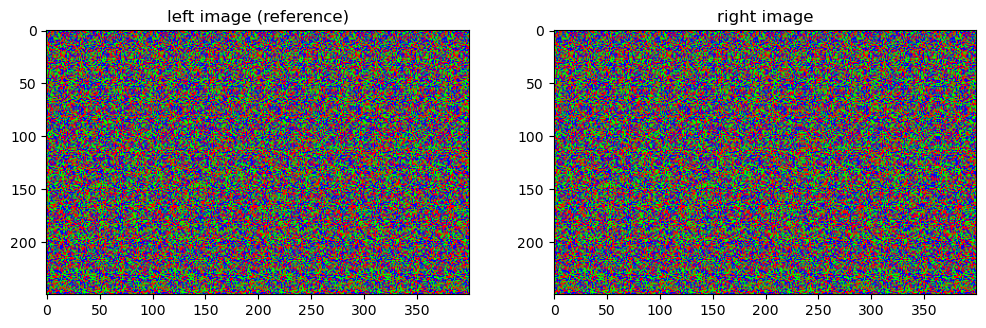

In [3]:
im_left = image.imread("stereo_pairs/rds_left.gif")
im_right = image.imread("stereo_pairs/rds_right.gif")

fig = plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(122)
plt.title("right image")
plt.imshow(im_right)

# the range of disparities for this random dot stereo pair 
d_min = 0
d_max = 2

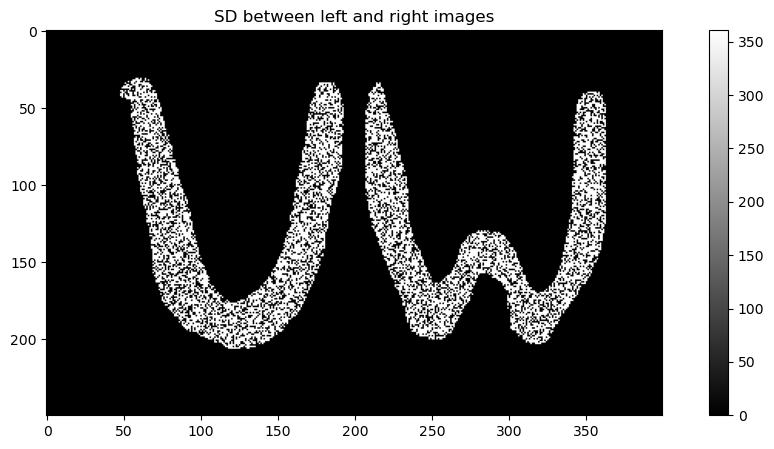

In [4]:
# compute and visualize (as an image) an array of "squared differences"
#    between RGB pixel values in the left and the right images.
SD = np.zeros(np.shape(im_left)) 

left_copy = im_left.copy()[:,:,:].astype(float)
right_copy = im_right.copy()[:,:,:].astype(float)

SD = left_copy - right_copy

SD = la.norm(SD, axis=2)


fig = plt.figure(figsize = (12, 5))
plt.title("SD between left and right images")
plt.imshow(SD, cmap = "gray")
plt.colorbar()

In [5]:
# computing squared differences between RGB pixel values in the reference (left) image and the "shifted" right 
#     image for ALL shifts/disparities in the corresponding range
def SD_array(imageL, imageR, d_minimum, d_maximum):
    # initialization of the array of "squared differences" for different shifts
    SD = np.zeros((1+d_maximum-d_minimum,np.shape(imageL)[0],np.shape(imageL)[1]))
    i = d_minimum
    index = 0
    while i <= d_maximum:
        temp = imageL - np.roll(imageR, i, axis = 1)
        SD[index] = la.norm(temp, axis=2)
        i = i + 1
        index = index + 1
    
    return SD

(250, 400, 4)
(250, 400, 4)
(3, 250, 400)


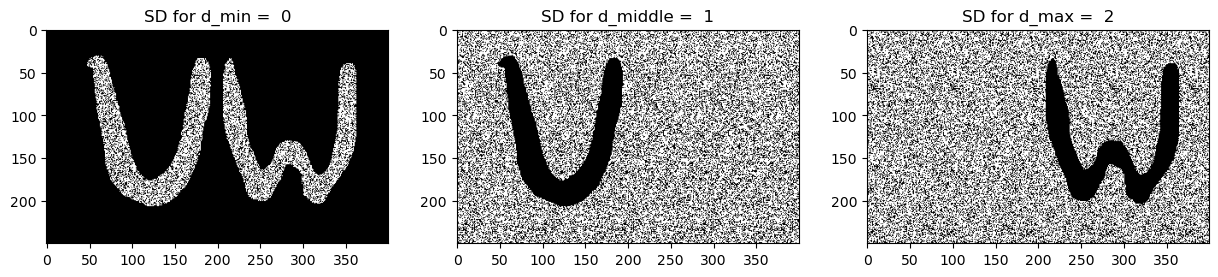

In [6]:
# Use SD_array function to compute SD images for the random dot stereo pair.
#     And visualize with min, max, (min+max)/2
SD = SD_array(im_left, im_right, d_min, d_max)    
print(np.shape(im_left))
print(np.shape(im_right))
print(np.shape(SD))

fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(SD[0], cmap = "gray")
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(SD[d_middle-d_min], cmap = "gray")
plt.subplot(133)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(SD[d_max-d_min], cmap = "gray")
#plt.colorbar(cax=plt.axes([0.91, 0.25, 0.01, 0.5]))

In [7]:
# Function integral_image can be applied to any scalar 2D array/image. 
# This function should return a double/float64 (precision) array/image of the same size.
# NOTE: it is safer to explicitly specify double/float64 precision for integral images since 
# later we will be adding/subtracting ("differenting") their values in nearby pixels .

def integral_image(img):
    img = img.astype(np.double)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i==0 and j==0:
                continue
            elif i==0:
                img[i][j] = img[i][j-1] + img[i][j]
            elif j==0:
                img[i][j] = img[i-1][j] + img[i][j]
            else:
                img[i][j] = img[i-1][j] + img[i][j-1] - img[i-1][j-1] + img[i][j]
    return img

(3, 250, 400) (3, 250, 400)


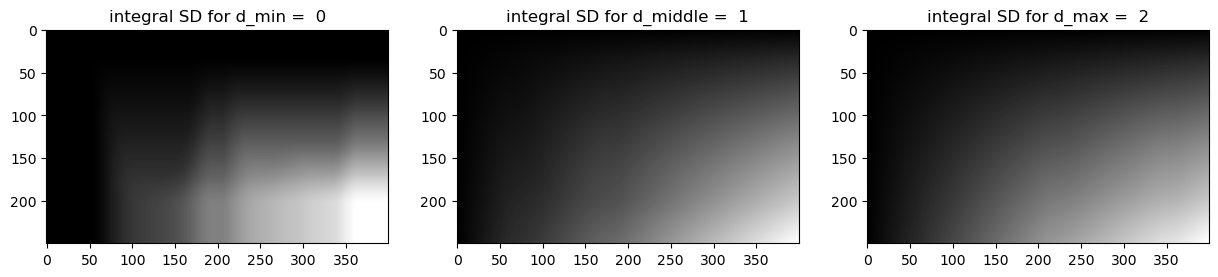

In [8]:
# apply intergral_image function to the squared difeerence for each disparity
integral_SD = np.zeros(np.shape(SD))
print(np.shape(integral_SD),np.shape(SD))

for Delta in range(1+d_max-d_min):
    integral_SD[Delta] = integral_image(SD[Delta])
        
fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('integral SD for d_min = {:>2d}'.format(d_min))
plt.imshow(integral_SD[0], cmap = "gray")
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('integral SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(integral_SD[d_middle-d_min], cmap = "gray")
plt.subplot(133)
plt.title('integral SD for d_max = {:>2d}'.format(d_max))
plt.imshow(integral_SD[d_max-d_min], cmap = "gray")
#plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

For windSum part, in HW3, I did not use integral_image function. The following is the revised version using integral_image and np.roll.

In [17]:
# windSum sums the elements of the input image within fixed-size windows around image pixels.
# function windSum can be applied to any scalar 2D array/image. It should return an array/image where the value of 
# each element (pixel p) is the "sum" of the values in the input array/image within a window around element p.
# The return image should be of the same size/type and have its margins (around half-window width) filled with INFTY.
INFTY = np.inf

def windSum(img, window_width):
    rb = math.floor(window_width/2)
    lt = -1
    if window_width%2==0:
        lt = rb - 1
    else:
        lt = rb
    
    intg = integral_image(img)
    temp = img.copy()
    
    intbr = np.roll(np.roll(intg, -rb, axis=0), -rb, axis=1)
    intbl = np.roll(np.roll(intg, lt+1, axis=0), -rb, axis=1)
    inttr = np.roll(np.roll(intg, -rb, axis=0), lt+1, axis=1)
    inttl = np.roll(np.roll(intg, lt+1, axis=0), lt+1, axis=1)
    
    temp = intbr - intbl - inttr + inttl

    if lt!=0:
        temp[:lt,:] = INFTY
        temp[:,:lt] = INFTY
    if rb!=0:
        temp[-rb:,:] = INFTY
        temp[:,-rb:] = INFTY
    
    return temp

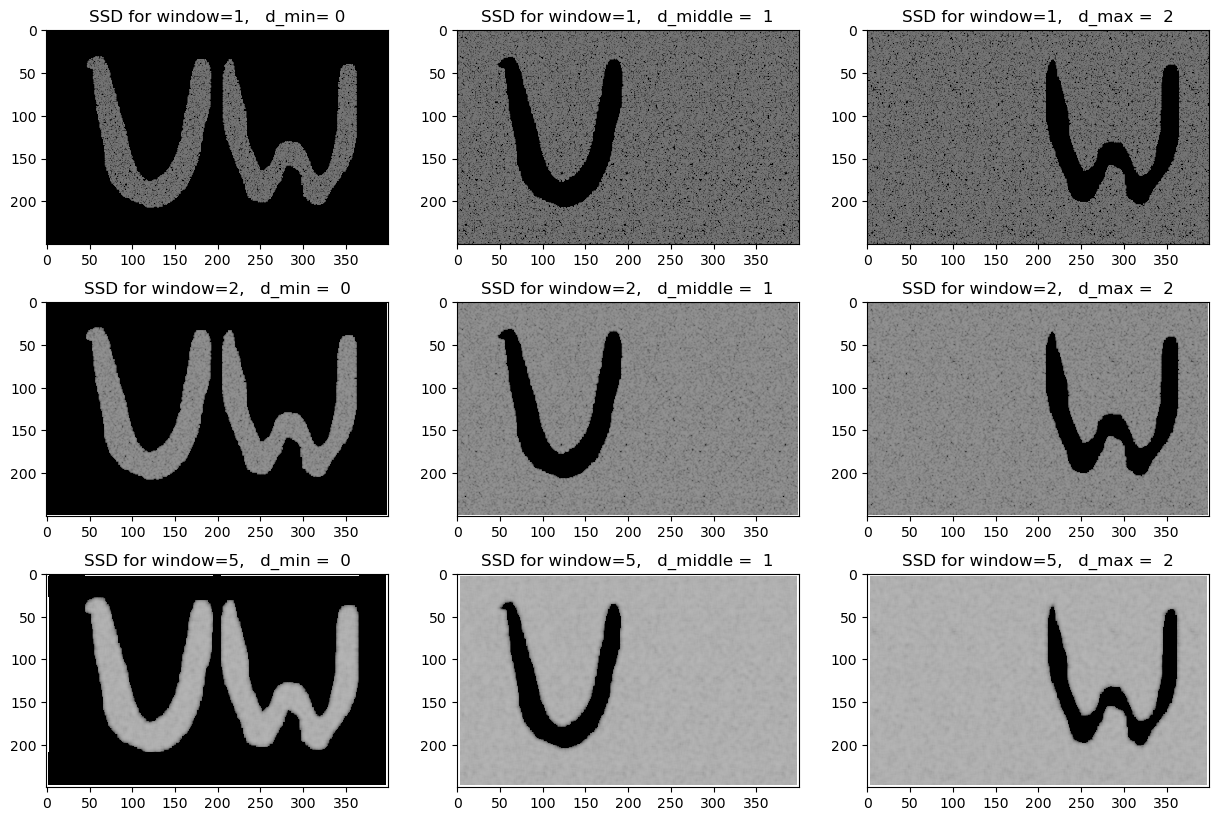

In [18]:
# Compute SSD images for windows of different widths and for different disparities by applying windSum function
#     to the "squared differences" SD.
SSD1 = np.zeros(np.shape(SD))
SSD2 = np.zeros(np.shape(SD))
SSD5 = np.zeros(np.shape(SD))

for Delta in range(1+d_max-d_min):
    SSD1[Delta] = windSum(SD[Delta],1)
    SSD2[Delta] = windSum(SD[Delta],2)
    SSD5[Delta] = windSum(SD[Delta],5)
    
d_middle = round((d_min+d_max)/2)


fig = plt.figure(figsize = (15, 10))
plt.subplot(331)
plt.title('SSD for window=1,   d_min={:>2d}'.format(d_min))
plt.imshow(1+SSD1[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(332) 
plt.title('SSD for window=1,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD1[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(333)
plt.title('SSD for window=1,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD1[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(334)
plt.title('SSD for window=2,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD2[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(335) 
plt.title('SSD for window=2,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD2[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(336)
plt.title('SSD for window=2,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD2[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(337)
plt.title('SSD for window=5,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD5[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(338) 
plt.title('SSD for window=5,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD5[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(339)
plt.title('SSD for window=5,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD5[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))

In [19]:
# computing "disparity map" from SSD arrays for each disparity in the range specified by dmin dmax.
#     return a disparity map.
def SSDtoDmap(SSD_array, d_minimum, d_maximum):
    records = np.full(np.shape(SSD_array[0]),INFTY)
    dMap = np.full(np.shape(SSD_array[0]),INFTY)
    for i in range(SSD_array.shape[0]):
        dMap = np.where(records<=SSD_array[i], dMap, i+d_minimum).copy()
        records = np.where(records<=SSD_array[i], records, SSD_array[i]).copy()

    return dMap

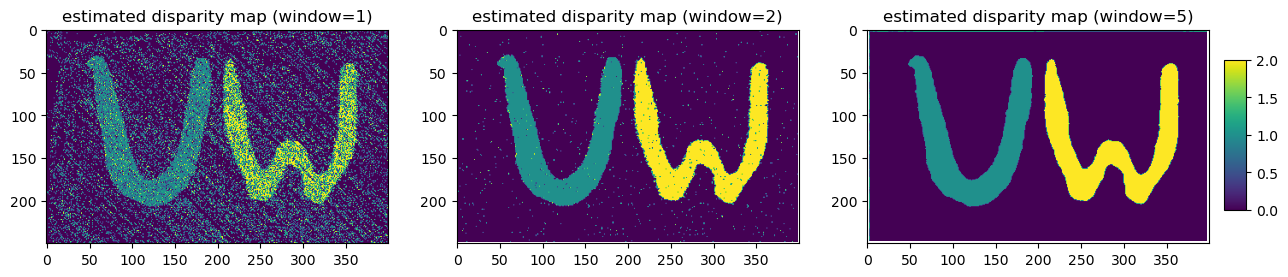

In [20]:
# compute and show disparity map
dMap1 = SSDtoDmap(SSD1,d_min,d_max)
dMap2 = SSDtoDmap(SSD2,d_min,d_max)
dMap5 = SSDtoDmap(SSD5,d_min,d_max)

fig = plt.figure(figsize = (15, 3))
plt.subplot(131)
plt.title("estimated disparity map (window=1)")
plt.imshow(dMap1, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("estimated disparity map (window=2)")
plt.imshow(dMap2, vmin = 0, vmax = d_max)
plt.subplot(133)
plt.title("estimated disparity map (window=5)")
plt.imshow(dMap5, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.25, 0.015, 0.5]))

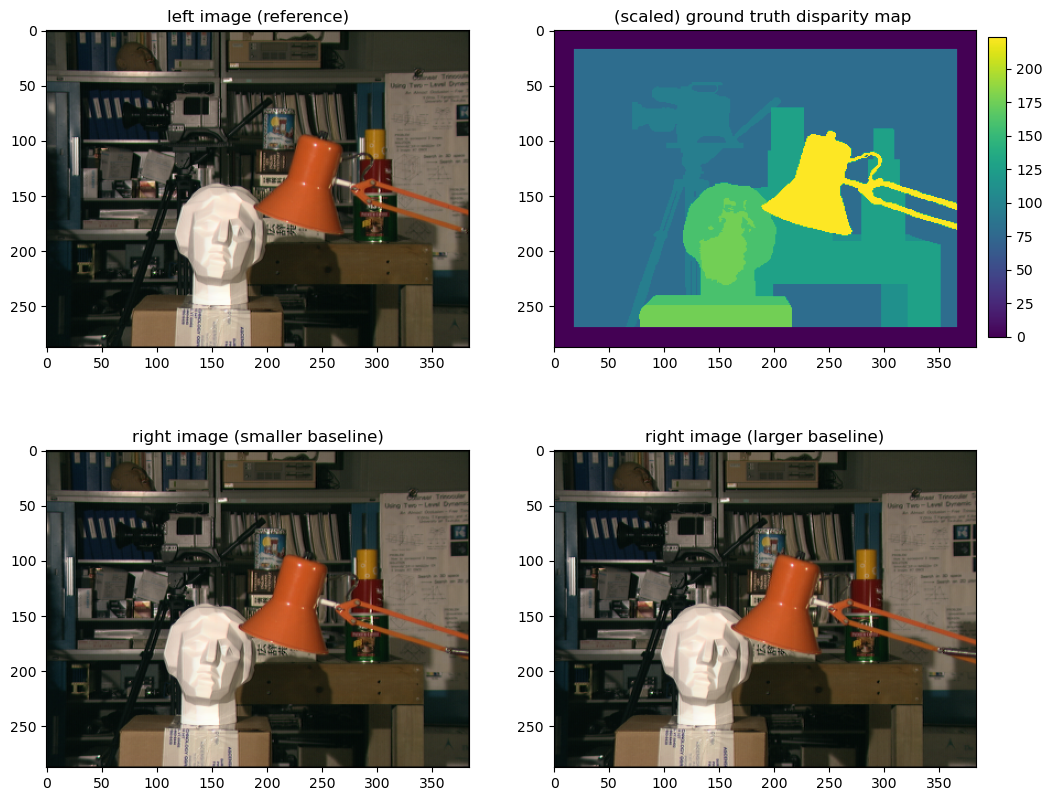

In [21]:
# Test on a real stereo pair with ground truth (Tsukuba)
im_left = image.imread("stereo_pairs/tsukuba/scene1.row3.col3.ppm")
im_gt = image.imread("stereo_pairs/tsukuba/truedisp.row3.col3.pgm")
im_right = image.imread("stereo_pairs/tsukuba/scene1.row3.col4.ppm")
im_right2 = image.imread("stereo_pairs/tsukuba/scene1.row3.col5.ppm")

fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(222) 
plt.title("(scaled) ground truth disparity map ")
plt.imshow(im_gt)
plt.colorbar(cax=plt.axes([0.91, 0.557, 0.015, 0.3]))
plt.subplot(223)
plt.title("right image (smaller baseline)")
plt.imshow(im_right)
plt.subplot(224)
plt.title("right image (larger baseline)")
plt.imshow(im_right2)

In [26]:
d_min = 6
d_max = 15

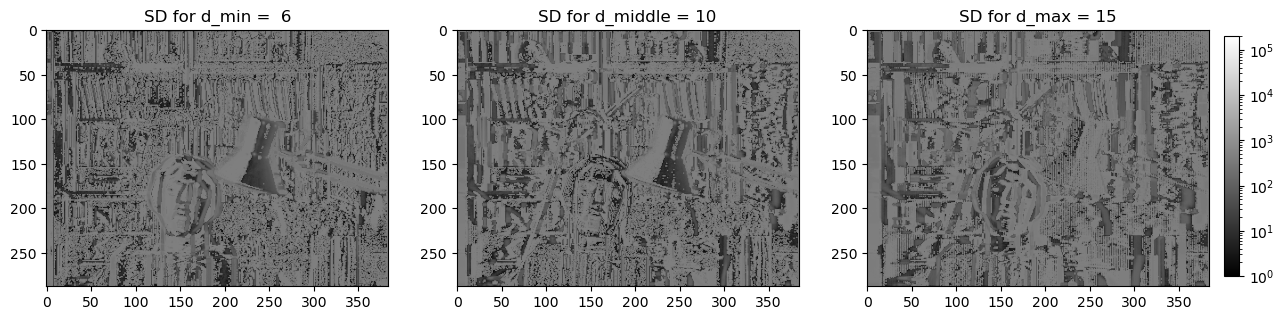

In [27]:
# compute squared differences using SD_array function and visualize the results using logarithmic scale.
SD = SD_array(im_left, im_right, d_min, d_max)    
    
fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(im_left)
plt.imshow(1+SD[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SD[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(133)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(1+SD[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

In [29]:
# Damp_Windows returns disparith map from a given stereo pair, specified disparity range, and window size
def Dmap_Windows(imageL, imageR, d_minimum, d_maximum, window_width):
    SD = SD_array(imageL, imageR, d_minimum, d_maximum)
    SSD = np.zeros(np.shape(SD))
    for Delta in range(1+d_max-d_min):
        SSD[Delta] = windSum(SD[Delta],window_width)
    dMap = SSDtoDmap(SSD,d_minimum,d_maximum)
    return dMap

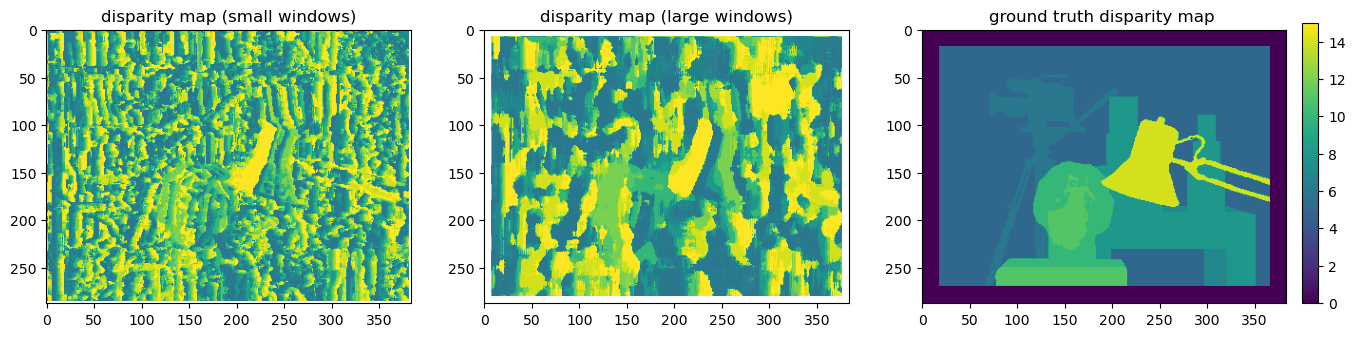

In [30]:
# compute and show disparity maps for Tsukuba using small and large windows
dispMap_small = Dmap_Windows(im_left, im_right, d_min, d_max, 4)
dispMap_large = Dmap_Windows(im_left, im_right, d_min, d_max, 15)

fig = plt.figure(figsize = (16, 7))
plt.subplot(131)
plt.title("disparity map (small windows)")
plt.imshow(dispMap_small, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("disparity map (large windows)")
plt.imshow(dispMap_large, vmin = 0, vmax = d_max)
plt.subplot(133) 
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

The above part if mostly from HW3 (except the windSum function). Obviously, there is a lot of noises through window based. And huge difference between the output disparity map and ground truth disparity map.

Next step is to implement the scan-line stereo.